python -m venv yolo_env
source yolo_env/bin/activate
pip install notebook ipykernel
pip install --upgrade pip
python -m ipykernel install --user --name=yolo_env --display-name "Python (yolo_env)"
pip install torch
pip install ultralytics
pip install opencv-python
pip install pymunk
pip install numpy
pip install matplotlib

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/aiffel/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 736x1280 1 frame, 1 red ball, 1 table, 1 white ball, 1 yellow ball, 64.7ms
Speed: 14.4ms preprocess, 64.7ms inference, 597.8ms postprocess per image at shape (1, 3, 736, 1280)
Table: {'cls_name': 'table', 'x1': tensor(381.6940, device='cuda:0'), 'y1': tensor(178.7554, device='cuda:0'), 'x2': tensor(1535.1182, device='cuda:0'), 'y2': tensor(751.3900, device='cuda:0'), 'confidence': tensor(0.9720, device='cuda:0')}
Objects: [{'cls_name': 'frame', 'x1': tensor(322.2486, device='cuda:0'), 'y1': tensor(113.8523, device='cuda:0'), 'x2': tensor(1605.1394, device='cuda:0'), 'y2': tensor(820.5328, device='cuda:0'), 'confidence': tensor(0.9618, device='cuda:0')}, {'cls_name': 'white b

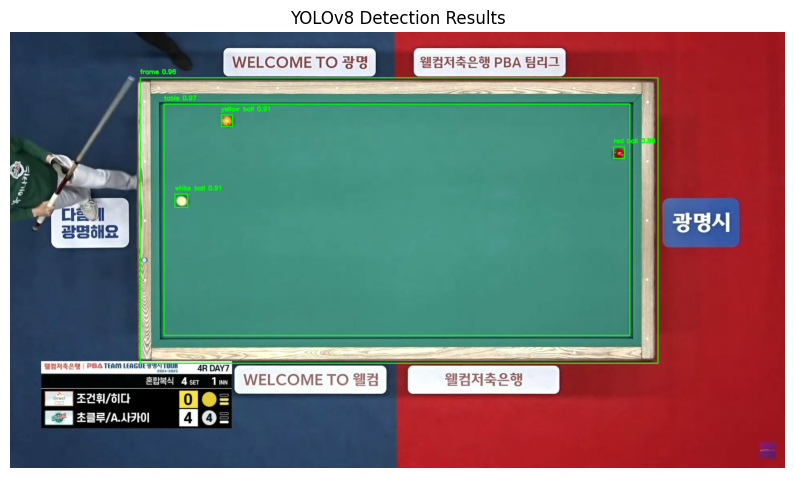

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  

from ultralytics import YOLO
import cv2
import torch

#------------------------------------------------------------
# 1) 모델 로드
#------------------------------------------------------------
# - 'best_jihye.pt'라는 파일에서 학습된 YOLO 모델을 로드합니다.
# - ultralytics 라이브러리의 YOLO 클래스를 사용하여 모델을 인스턴스화합니다.
#------------------------------------------------------------
# [파라미터 변경 가능]
#  - model_path: 모델 가중치 파일 경로
#  - device: "cpu" 또는 "cuda" 등 추론에 사용할 디바이스 지정 가능 (예: YOLO(model_path, device="cuda:0"))
#------------------------------------------------------------
model_path = "best_jihye.pt"
model = YOLO(model_path)

#------------------------------------------------------------
# 2) 이미지 로드
#------------------------------------------------------------
# - OpenCV의 imread 함수를 사용하여 "test_img.jpg" 이미지를 불러옵니다.
# - 불러온 이미지가 None(로드 실패)이면 예외 처리합니다.
#------------------------------------------------------------
# [파라미터 변경 가능]
#  - image_path: 추론할 이미지 파일 경로
#------------------------------------------------------------
image_path = "test_img.jpg"
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image: {image_path}")

#------------------------------------------------------------
# 3) 모델 추론
#------------------------------------------------------------
# - 로드한 YOLO 모델을 이용해 이미지에 대한 객체 검출(prediction)을 수행합니다.
# - conf=0.5로 설정해 신뢰도 0.5 이상의 바운딩 박스만 고려합니다.
#------------------------------------------------------------
# [파라미터 변경 가능]
#  - conf: 최소 신뢰도 임계값
#  - iou: IoU(교집합-합집합 비율) 임계값 (기본값 0.45 정도)
#  - imgsz: 추론 시 리사이즈할 이미지 크기 (예: 640)
#  - 예: results = model.predict(source=image, conf=0.5, iou=0.5, imgsz=640)
#------------------------------------------------------------
results = model.predict(source=image, conf=0.5)

#------------------------------------------------------------
# 4) 객체 정보 저장용 변수 선언
#------------------------------------------------------------
# - table (당구대) 정보를 저장할 변수
# - objects (다른 객체들) 정보를 저장할 리스트
#------------------------------------------------------------
table = None
objects = []

#------------------------------------------------------------
# 5) 바운딩 박스 표시 및 결과 처리
#------------------------------------------------------------
# - YOLO 모델은 여러 개의 detection 결과(results)를 반환합니다.
# - 각 detection에는 여러 바운딩 박스(boxes)가 포함됩니다.
# - 바운딩 박스 좌표를 OpenCV를 통해 이미지에 시각적으로 표시하고,
#   당구대(table)와 나머지 객체(objects)들을 분류합니다.
#------------------------------------------------------------
for result in results:
    for box in result.boxes:
        # 바운딩 박스 좌표와 신뢰도, 클래스 ID
        x1, y1, x2, y2 = box.xyxy[0]  # 좌상단(x1, y1), 우하단(x2, y2)
        conf = box.conf[0]           # 바운딩 박스 신뢰도
        cls_id = int(box.cls[0])     # 클래스 ID
        
        # 그리기 위해 정수 좌표로 변환
        ix1, iy1, ix2, iy2 = map(int, [x1, y1, x2, y2])

        # 클래스 ID를 실제 클래스 명으로 매핑
        class_map = {
            0: "blue ball", 
            1: "frame", 
            2: "red ball", 
            3: "table",
            4: "white ball", 
            5: "yellow ball"
        }
        cls_name = class_map.get(cls_id, f"Unknown({cls_id})")

        #------------------------------------------------------------
        # 바운딩 박스 시각화
        #------------------------------------------------------------
        # [파라미터 변경 가능]
        #  - 색상, 두께 등 OpenCV의 사각형 및 텍스트 옵션 조정 가능
        #  - 예: cv2.rectangle(image, (ix1, iy1), (ix2, iy2), (255, 0, 0), 3)
        #        -> 파란색, 두께 3
        #------------------------------------------------------------
        cv2.rectangle(image, (ix1, iy1), (ix2, iy2), (0, 255, 0), 2)

        # 바운딩 박스 위에 라벨(클래스명 + 신뢰도) 그리기
        label = f"{cls_name} {conf:.2f}"
        cv2.putText(
            image, label, (ix1, max(iy1 - 10, 0)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
        )

        #--------------------------------------------------------
        # 당구대(table)이면 table 변수에 저장,
        # 나머지 객체들(objects) 리스트에 저장
        #--------------------------------------------------------
        if cls_id == 3:  # 클래스 ID가 3이면 당구대(table)
            table = {
                "cls_name": "table",
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "confidence": conf
            }
        else:
            objects.append({
                "cls_name": cls_name,
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "confidence": conf
            })

#------------------------------------------------------------
# 테이블이 검출되지 않은 경우 기본값 설정
#------------------------------------------------------------
# - table 변수가 None이면, 기본 좌표(0,0,1280,720)와 신뢰도 1.0으로 설정
#------------------------------------------------------------
# [파라미터 변경 가능]
#  - 기본 테이블 사이즈: (0,0,1280,720)
#------------------------------------------------------------
if table is None:
    table = {
        "cls_name": "table(default)",
        "x1": 0, "y1": 0, "x2": 1280, "y2": 720,
        "confidence": 1.0
    }

#------------------------------------------------------------
# 결과 출력 (개발/디버그용)
#------------------------------------------------------------
print("Table:", table)
print("Objects:", objects)

#------------------------------------------------------------
# 시각화 (디버깅용)
#------------------------------------------------------------
# - OpenCV로 작업했던 이미지는 BGR 채널이므로,
#   matplotlib 시각화를 위해 RGB로 변환 후 표시합니다.
#------------------------------------------------------------
# [파라미터 변경 가능]
#  - figsize: Matplotlib에서 이미지 표시 시 창 크기
#------------------------------------------------------------
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("YOLOv8 Detection Results")
plt.show()


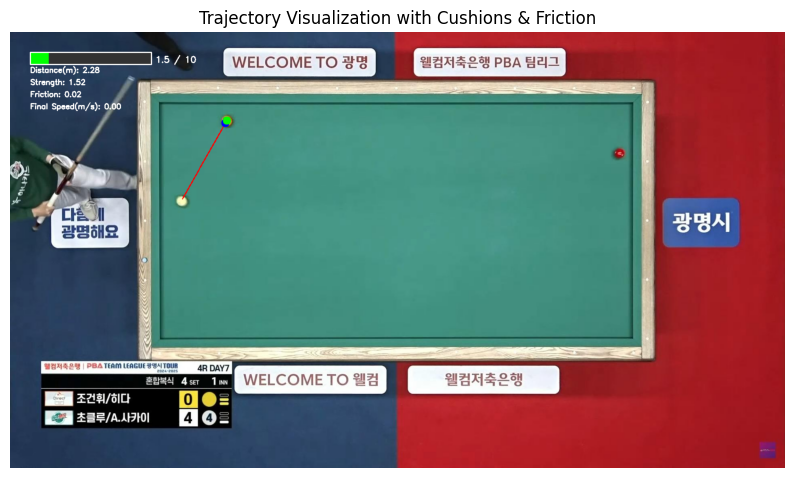

In [8]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch  # 텐서 변환을 위해 필요
import cv2
import matplotlib.pyplot as plt

##############################################################################
# 헬퍼 함수: GPU 텐서 -> CPU float 변환
##############################################################################
def to_cpu_float(value):
    """
    텐서(tensor)이든 파이썬 숫자이든 상관없이,
    파이썬 float으로 안전하게 변환해주는 함수.
    - torch.Tensor일 경우 detach().cpu().item()을 통해 CPU 상의 숫자로
      가져온 뒤 float으로 변환
    - 일반 숫자(float/int)면 그냥 float(value) 처리
    """
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    else:
        return float(value)

##############################################################################
# 2-1) 공 좌표 추출
##############################################################################
# YOLO 객체 검출 결과인 objects, table 변수를 활용하여,
#   - 흰 공(white ball)
#   - 목표 공(red ball 또는 yellow ball)
# 의 위치(바운딩 박스 중앙)를 추출합니다.

# 1) YOLO 결과에서 흰 공, 목표 공 찾기
white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
target_ball = next(obj for obj in objects if obj["cls_name"] in ["red ball", "yellow ball"])

# 2) GPU 텐서일 수도 있으므로 안전하게 CPU float으로 변환
white_x1 = to_cpu_float(white_ball["x1"])
white_y1 = to_cpu_float(white_ball["y1"])
white_x2 = to_cpu_float(white_ball["x2"])
white_y2 = to_cpu_float(white_ball["y2"])

target_x1 = to_cpu_float(target_ball["x1"])
target_y1 = to_cpu_float(target_ball["y1"])
target_x2 = to_cpu_float(target_ball["x2"])
target_y2 = to_cpu_float(target_ball["y2"])

# 3) 바운딩 박스 중앙 좌표 (픽셀 좌표) 계산
white_pos = np.array([
    (white_x1 + white_x2) / 2.0,
    (white_y1 + white_y2) / 2.0
])
target_pos = np.array([
    (target_x1 + target_x2) / 2.0,
    (target_y1 + target_y2) / 2.0
])

# 4) 테이블(당구대) 픽셀 정보도 변환
table_x1 = to_cpu_float(table["x1"])
table_y1 = to_cpu_float(table["y1"])
table_x2 = to_cpu_float(table["x2"])
table_y2 = to_cpu_float(table["y2"])

# 5) 픽셀 좌표 → 물리 좌표 변환 스케일
PIXELS_TO_METERS = 100.0  # 예: 100픽셀 = 1m 로 가정

# 6) Pymunk 월드 좌표 (m단위)로 변환
white_pos_world = (white_pos / PIXELS_TO_METERS).tolist() 
target_pos_world = (target_pos / PIXELS_TO_METERS).tolist()

##############################################################################
# 2-2) Pymunk 초기화
##############################################################################
# - Pymunk의 Space() 객체 생성
# - 중력을 0으로 설정 (수평 테이블 가정)
##############################################################################
space = pymunk.Space()
space.gravity = (0, 0)

##############################################################################
# 2-3) 테이블 경계(쿠션) 생성
##############################################################################
# - 당구대 가장자리(좌하, 우상, 등 4개 모서리)를 pymunk.Segment로 설정
# - 쿠션 탄성(elasticity)을 부여하여 공이 튕기도록 설정
#   (쿠션 두께는 단순히 충돌 감지용)
##############################################################################
table_world_min = (table_x1 / PIXELS_TO_METERS, table_y1 / PIXELS_TO_METERS)
table_world_max = (table_x2 / PIXELS_TO_METERS, table_y2 / PIXELS_TO_METERS)

cushion_thickness = 0.01  # 쿠션 두께(얇은 선 형태)
elasticity = 0.9

# 테이블 4면(위, 아래, 왼, 오른쪽)을 Segment로 생성
cushions = [
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_min[1]), 
                   (table_world_max[0], table_world_min[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_max[1]), 
                   (table_world_max[0], table_world_max[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_min[1]), 
                   (table_world_min[0], table_world_max[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_max[0], table_world_min[1]), 
                   (table_world_max[0], table_world_max[1]), 
                   cushion_thickness),
]

# 쿠션 탄성 설정 후, 시뮬레이션 공간에 추가
for c in cushions:
    c.elasticity = 0.9
    space.add(c)

##############################################################################
# 2-4) 공 생성
##############################################################################
# - 질량(mass), 반지름(radius)을 설정하고, 공을 Circle로 생성
# - 흰 공: 동적(Body.DYNAMIC)
# - 목표 공: 정적(Body.STATIC)
##############################################################################
mass = 1.0
radius = 0.05  # 0.05m = 지름 약 10cm
moment = pymunk.moment_for_circle(mass, 0, radius)  # 관성 모멘트

# 흰 공(동적)
white_ball_body = pymunk.Body(mass, moment)
white_ball_body.position = white_pos_world
white_ball_shape = pymunk.Circle(white_ball_body, radius)
white_ball_shape.elasticity = 0.9
space.add(white_ball_body, white_ball_shape)

# 목표 공(정적)
target_ball_body = pymunk.Body(body_type=pymunk.Body.STATIC)
target_ball_body.position = target_pos_world
target_ball_shape = pymunk.Circle(target_ball_body, radius)
space.add(target_ball_body, target_ball_shape)

##############################################################################
# 2-5) 초기 속도 및 방향 설정
##############################################################################
# - 흰 공을 목표 공 쪽으로 향하도록 방향 벡터 계산
# - 두 공의 중심 간 거리(distance)에 따라 strength(타격 강도) 설정
# - 일정 기준(max_distance) 이상이면 강도를 최대로 제한
##############################################################################
direction_vector = target_ball_body.position - white_ball_body.position
distance = direction_vector.length
direction_unit = direction_vector.normalized() if distance > 0 else Vec2d(1,0)

# 최대 거리를 15m로 가정, 실제 거리에 비례하여 최대 10의 강도
max_distance = 15.0
strength = min((distance / max_distance) * 10, 10)

# 속도(크기) 설정 (간단한 예: strength * 일정계수 = 속력)
initial_speed = strength * 2.0  # 예: 최대 20 m/s로 가정
white_ball_body.velocity = direction_unit * initial_speed

##############################################################################
# 2-6) 시뮬레이션 (마찰력 적용)
##############################################################################
# - space.step(dt)로 시뮬레이션 수행
# - 매 step마다 수동으로 마찰력을 적용해 속도를 조금씩 줄임
# - 흰 공 속도가 매우 작아지면 멈춤(0으로 설정)
##############################################################################
friction_coefficient = 0.02  # 마찰계수(값이 클수록 마찰 큼)

dt = 1/60.0         # 시간 스텝(초)
simulation_steps = 300  # 5초 간 시뮬레이션 (60fps * 5초)

positions = []  # 흰 공의 위치를 기록할 리스트
for step in range(simulation_steps):
    space.step(dt)
    
    # 수동 마찰 적용
    v = white_ball_body.velocity
    speed_now = v.length
    if speed_now > 0:
        friction_force = friction_coefficient * speed_now
        speed_new = max(speed_now - friction_force * dt, 0)
        if speed_new < 0.01:  # 거의 멈췄다고 판단
            white_ball_body.velocity = (0, 0)
        else:
            white_ball_body.velocity = v.normalized() * speed_new
    
    # 현재 위치 기록
    positions.append((white_ball_body.position.x, white_ball_body.position.y))

##############################################################################
# 2-7) 궤적 시각화 (OpenCV)
##############################################################################
# - 시뮬레이션으로 나온 흰 공의 이동 경로(positions)를 바탕으로,
#   원본 이미지 위에 선(line)으로 그려서 궤적을 표현
##############################################################################
# 1) 이미지 재로드
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Cannot load {image_path}")

# 2) 이동 경로를 순회하며, 연속된 위치를 선으로 연결
for i in range(len(positions) - 1):
    x1, y1 = positions[i]
    x2, y2 = positions[i + 1]

    # 월드좌표 → 픽셀 좌표 변환
    px1, py1 = int(x1 * PIXELS_TO_METERS), int(y1 * PIXELS_TO_METERS)
    px2, py2 = int(x2 * PIXELS_TO_METERS), int(y2 * PIXELS_TO_METERS)
    
    # 궤적 그리기 (빨간색 선)
    cv2.line(image, (px1, py1), (px2, py2), (0, 0, 255), 2)

# 3) 흰 공의 최종 위치에 파란 원 표시
final_px = int(white_ball_body.position.x * PIXELS_TO_METERS)
final_py = int(white_ball_body.position.y * PIXELS_TO_METERS)
cv2.circle(image, (final_px, final_py), 10, (255, 0, 0), -1)

# 4) 목표 공(정적) 위치에 초록색 원 표시
target_px = int(target_ball_body.position.x * PIXELS_TO_METERS)
target_py = int(target_ball_body.position.y * PIXELS_TO_METERS)
cv2.circle(image, (target_px, target_py), 10, (0, 255, 0), -1)

##############################################################################
# 2-8) 강도 게이지 바 및 디버그 텍스트
##############################################################################
# - 강도(strength) 시각화를 위해 화면에 게이지 바를 그립니다.
# - 디버그 정보(거리, 마찰계수, 최종 속도 등)도 텍스트로 표시합니다.
##############################################################################
def draw_gauge_bar(image, strength_val, max_strength=10, position=(50, 50), size=(300, 30)):
    """
    간단한 게이지 바를 그려주는 함수
    - image: OpenCV 이미지
    - strength_val: 현재 강도
    - max_strength: 최대 강도
    - position: 게이지 바 시작 좌표 (왼쪽 상단)
    - size: 게이지 바의 폭(width), 높이(height)
    """
    x, y = position
    width, height = size
    
    # 1) 배경(회색)
    cv2.rectangle(image, (x, y), (x + width, y + height), (50, 50, 50), -1)
    
    # 2) 채워진 게이지(녹색)
    current_width = int((strength_val / max_strength) * width)
    cv2.rectangle(image, (x, y), (x + current_width, y + height), (0, 255, 0), -1)
    
    # 3) 테두리(흰색)
    cv2.rectangle(image, (x, y), (x + width, y + height), (255, 255, 255), 2)
    
    # 4) 텍스트 (예: "3.5 / 10")
    label = f"{strength_val:.1f} / {max_strength}"
    cv2.putText(image, label, (x + width + 10, y + height - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# 강도 게이지 바 그리기
draw_gauge_bar(image, strength, position=(50, 50), size=(300, 30))

# 디버그 정보 표시
debug_info = [
    f"Distance(m): {distance:.2f}",
    f"Strength: {strength:.2f}",
    f"Friction: {friction_coefficient}",
    f"Final Speed(m/s): {white_ball_body.velocity.length:.2f}"
]

y_offset = 100
for info in debug_info:
    cv2.putText(image, info, (50, y_offset),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    y_offset += 30

##############################################################################
# 2-9) 결과 출력
##############################################################################
# - Matplotlib를 사용하여 최종적으로 궤적과 공의 위치가 표시된 이미지를 출력
##############################################################################
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.title("Trajectory Visualization with Cushions & Friction")
plt.axis("off")
plt.show()


[충돌 발생] 흰 공 속도: Vec2d(0.16659557128918506, -0.29359933593743043), 목표 공 속도: Vec2d(1.0340932307941484, -1.8224319140625695)
[충돌 발생] 흰 공 속도: Vec2d(0.1332764570313481, -0.2348794687499444), 목표 공 속도: Vec2d(0.8272745846353189, -1.4579455312500558)
[충돌 발생] 흰 공 속도: Vec2d(0.0, 0.0), 목표 공 속도: Vec2d(0.6608151432372238, 0.8426925170625319)
[충돌 발생] 흰 공 속도: Vec2d(0.0, 0.0), 목표 공 속도: Vec2d(0.528652114589779, 0.6741540136500256)
[충돌 발생] 흰 공 속도: Vec2d(0.0, 0.0), 목표 공 속도: Vec2d(0.42245719955641836, -0.3896610198897148)
[충돌 발생] 흰 공 속도: Vec2d(0.0, 0.0), 목표 공 속도: Vec2d(-0.24418026134360976, -0.3114377429012775)
[충돌 발생] 흰 공 속도: Vec2d(0.0, 0.0), 목표 공 속도: Vec2d(-0.19512962847002885, 0.18001101539693837)
[충돌 발생] 흰 공 속도: Vec2d(0.0, 0.0), 목표 공 속도: Vec2d(-0.1561037027760231, 0.14400881231755067)
[최종 위치] 흰 공: (1190.15, 567.63)
[최종 위치] 목표 공: (1069.37, 555.64)


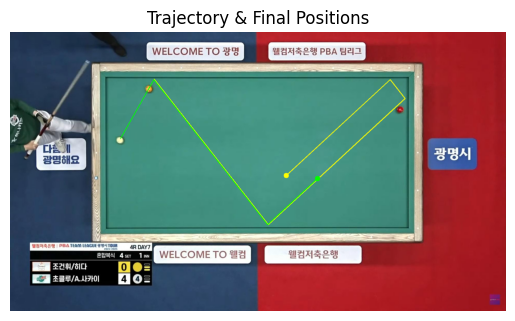

In [6]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

##############################################################################
# 0) 헬퍼 함수: GPU 텐서 -> CPU float 변환
##############################################################################
def to_cpu_float(value):
    """
    텐서(tensor)이거나 일반 파이썬 숫자 타입 여부에 상관없이
    안전하게 float으로 변환해주는 함수입니다.

    - torch.Tensor인 경우:
        value.detach().cpu().item()을 통해 CPU 상의 단일 숫자로 추출 후 float으로 변환
    - 그 외(float/int 등)는 그냥 float(value)로 처리
    """
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

##############################################################################
# 1) 흰 공, 목표 공 좌표 추출 + 테이블 좌표
##############################################################################
# - YOLO에서 검출된 객체들(objects) 중 흰 공(white ball)과 목표 공(red ball 또는 yellow ball)을 찾습니다.
# - 각 공의 바운딩 박스 (x1,y1,x2,y2)로부터 중심 좌표(픽셀)를 구합니다.
##############################################################################

# 흰 공, 목표 공 찾기
white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
target_ball = next(obj for obj in objects if obj["cls_name"] in ["red ball", "yellow ball"])

# 흰 공 바운딩 박스 좌표
wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])

# 목표 공 바운딩 박스 좌표
tx1, ty1 = to_cpu_float(target_ball["x1"]), to_cpu_float(target_ball["y1"])
tx2, ty2 = to_cpu_float(target_ball["x2"]), to_cpu_float(target_ball["y2"])

# 중심점(픽셀 좌표) 계산
white_pos = np.array([(wx1 + wx2) / 2.0, (wy1 + wy2) / 2.0])
target_pos = np.array([(tx1 + tx2) / 2.0, (ty1 + ty2) / 2.0])

# 픽셀 -> 월드 좌표로의 스케일링(예: 100픽셀 = 1m)
PIXELS_TO_METERS = 100.0
white_pos_world = (white_pos / PIXELS_TO_METERS).tolist()   # [x(m), y(m)]
target_pos_world = (target_pos / PIXELS_TO_METERS).tolist() # [x(m), y(m)]

##############################################################################
# 2) Pymunk 초기화 + 테이블 경계(쿠션) 생성
##############################################################################
# - Pymunk의 Space()를 만들고, 중력(gravity)을 (0,0)으로 설정 (수평 테이블 가정)
# - 테이블의 좌하단(table_world_min), 우상단(table_world_max)을 이용해
#   쿠션을 Segment 형태로 만들어 둥근 공이 반사되도록 합니다.
##############################################################################
space = pymunk.Space()
space.gravity = (0, 0)

# 테이블 최소/최대 월드 좌표
table_world_min = (table["x1"] / PIXELS_TO_METERS, table["y1"] / PIXELS_TO_METERS)
table_world_max = (table["x2"] / PIXELS_TO_METERS, table["y2"] / PIXELS_TO_METERS)

# 쿠션(테이블 경계) 두께(얇은 선 형태), 1cm 정도로 가정
cushion_thickness = 0.01
cushions = [
    # 아래쪽 쿠션
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_min[1]), 
                   (table_world_max[0], table_world_min[1]), 
                   cushion_thickness),
    # 위쪽 쿠션
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_max[1]), 
                   (table_world_max[0], table_world_max[1]), 
                   cushion_thickness),
    # 왼쪽 쿠션
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_min[1]), 
                   (table_world_min[0], table_world_max[1]), 
                   cushion_thickness),
    # 오른쪽 쿠션
    pymunk.Segment(space.static_body, 
                   (table_world_max[0], table_world_min[1]), 
                   (table_world_max[0], table_world_max[1]), 
                   cushion_thickness),
]

# 쿠션 탄성과 마찰 설정 후 space에 추가
for c in cushions:
    c.elasticity = 0.85  # 탄성(충돌 시 반사 효과)
    c.friction = 0.01    # 쿠션 표면의 마찰
    space.add(c)

##############################################################################
# 3) 공 생성 (동적)
##############################################################################
# - 흰 공과 목표 공을 각각 Circle 형태로 생성
# - pymunk에서 Circle을 만들려면 Body(질량, 관성모멘트 등)와 Shape(반지름 등)를 정의해야 함
# - 여기서는 두 공 모두 동적(Body.DYNAMIC)으로 설정 (원한다면 목표 공은 STATIC도 가능)
##############################################################################
mass = 1.0
radius = 0.05  # 공의 반지름(5cm)
moment = pymunk.moment_for_circle(mass, 0, radius)

# 흰 공
white_ball_body = pymunk.Body(mass, moment)
white_ball_body.position = white_pos_world
white_ball_shape = pymunk.Circle(white_ball_body, radius)
white_ball_shape.elasticity = 0.85
white_ball_shape.friction = 0.05  # 표면 마찰
white_ball_shape.collision_type = 0  # 충돌 타입 식별용
space.add(white_ball_body, white_ball_shape)

# 목표 공
target_ball_body = pymunk.Body(mass, moment)
target_ball_body.position = target_pos_world
target_ball_shape = pymunk.Circle(target_ball_body, radius)
target_ball_shape.elasticity = 0.85
target_ball_shape.friction = 0.05
target_ball_shape.collision_type = 1  # 충돌 타입 식별용
space.add(target_ball_body, target_ball_shape)

##############################################################################
# 4) 충돌 핸들러 등록
##############################################################################
# - 흰 공( collision_type=0 )과 목표 공( collision_type=1 )이 충돌할 때 실행되는 함수를 등록합니다.
# - post_solve 단계에서 각 공의 속도를 약간 감소(에너지 손실)시키는 예시로 구현
##############################################################################
def handle_collision(arbiter, space, data):
    """
    흰 공과 목표 공이 충돌 시 호출되는 콜백 함수
    - 충돌 후 속도를 약간 감소시켜 (에너지 손실) 물리적 리얼리티를 살짝 가정
    - print 문으로 디버그 정보 확인 가능
    """
    shapes = arbiter.shapes
    white_body = shapes[0].body
    target_body = shapes[1].body

    # 충돌 시 속도 80%로 감소
    white_body.velocity *= 0.8
    target_body.velocity *= 0.8

    print(f"[충돌 발생] 흰 공 속도: {white_body.velocity}, 목표 공 속도: {target_body.velocity}")
    return True  # 충돌을 유효 처리

collision_handler = space.add_collision_handler(0, 1)  # 0번과 1번 충돌 타입
collision_handler.post_solve = handle_collision       # 충돌 후 처리

##############################################################################
# 5) 흰 공 초기 속도 부여
##############################################################################
# - 흰 공을 목표 공 방향으로 향하게 하여, 초기 속도를 부여
# - 두 공 사이 거리 기준으로 strength 계산
##############################################################################
direction_vector = (target_ball_body.position - white_ball_body.position)
distance = direction_vector.length
direction_unit = direction_vector.normalized() if distance > 0 else Vec2d(1, 0)

# 최대 거리 15m로 가정, 그 비율에 따라 최대 강도 10
strength = min((distance / 15.0) * 10, 10)
white_ball_body.velocity = direction_unit * strength * 2.0  # 예: (강도 * 2) m/s

##############################################################################
# 6) 시뮬레이션 수행
##############################################################################
# - 매 프레임(step)마다 space.step(dt)로 갱신
# - 공의 속도가 일정 임계치 이하로 작아지면(멈춘 상태로 간주), 0으로 설정
# - 모든 공이 멈추면 시뮬레이션 종료
##############################################################################
friction_coefficient = 0.02  # (코드 내에서 별도로 사용하지 않았지만, 필요 시 사용 가능)
dt = 1/60.0         # 시간 간격(초)
max_steps = 3000    # 최대 시뮬레이션 스텝
stop_threshold = 0.01  # 속도가 이 값 이하일 때 멈췄다고 판단

positions_w, positions_t = [], []  # 흰 공/목표 공 위치 기록 리스트

for step in range(max_steps):
    space.step(dt)

    # 흰 공 속도가 매우 낮아지면 멈춤 처리
    if white_ball_body.velocity.length < stop_threshold:
        white_ball_body.velocity = Vec2d(0, 0)

    # 목표 공 속도도 동일 처리
    if target_ball_body.velocity.length < stop_threshold:
        target_ball_body.velocity = Vec2d(0, 0)

    # 각 공의 현재 위치 저장 (시각화용)
    positions_w.append((white_ball_body.position.x, white_ball_body.position.y))
    positions_t.append((target_ball_body.position.x, target_ball_body.position.y))

    # 둘 다 멈추면 시뮬레이션 종료
    if (white_ball_body.velocity.length < stop_threshold and 
        target_ball_body.velocity.length < stop_threshold):
        print(f"[시뮬레이션 종료] Step {step}")
        break

##############################################################################
# 7) 최종 결과 출력 및 궤적 시각화
##############################################################################
# - OpenCV로 공 궤적 라인을 그린 뒤, Matplotlib로 시각화
##############################################################################

# 최종 위치(월드좌표 -> 픽셀)
final_white_pos = white_ball_body.position * PIXELS_TO_METERS
final_target_pos = target_ball_body.position * PIXELS_TO_METERS

print(f"[최종 위치] 흰 공: ({final_white_pos.x:.2f}, {final_white_pos.y:.2f})")
print(f"[최종 위치] 목표 공: ({final_target_pos.x:.2f}, {final_target_pos.y:.2f})")

# 원본 이미지 로드
image = cv2.imread(image_path)

# 흰 공, 목표 공 궤적을 프레임 전체에 걸쳐 그리기
for i in range(len(positions_w) - 1):
    # 흰 공
    px_w1, py_w1 = int(positions_w[i][0] * PIXELS_TO_METERS), int(positions_w[i][1] * PIXELS_TO_METERS)
    px_w2, py_w2 = int(positions_w[i+1][0] * PIXELS_TO_METERS), int(positions_w[i+1][1] * PIXELS_TO_METERS)
    cv2.line(image, (px_w1, py_w1), (px_w2, py_w2), (0, 255, 0), 2)  # 녹색 라인

    # 목표 공
    px_t1, py_t1 = int(positions_t[i][0] * PIXELS_TO_METERS), int(positions_t[i][1] * PIXELS_TO_METERS)
    px_t2, py_t2 = int(positions_t[i+1][0] * PIXELS_TO_METERS), int(positions_t[i+1][1] * PIXELS_TO_METERS)
    cv2.line(image, (px_t1, py_t1), (px_t2, py_t2), (0, 255, 255), 2)  # 노란색 라인

# 최종 위치 표시(원)
cv2.circle(image, (int(final_white_pos.x), int(final_white_pos.y)), 10, (0, 255, 0), -1)
cv2.circle(image, (int(final_target_pos.x), int(final_target_pos.y)), 10, (0, 255, 255), -1)

# OpenCV -> matplotlib 표시를 위해 RGB 변환
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Trajectory & Final Positions")
plt.show()


[초기 설정] 흰 공 초기 속도: Vec2d(1.974046639298664, -3.4789567208968917), 힘: 2
[Step 0] 흰 공 속도: 4.00, 목표 공 속도: 0.00
[충돌 발생] 법선 벡터: Vec2d(0.49351165982473194, -0.8697391802241854)
[충돌 발생] 충격량(impulse): Vec2d(-0.9672828532564745, 1.7046887932394033)
[충돌 발생] 흰 공 속도: Vec2d(1.2772081756261784, -2.250884998420321), 목표 공 속도: Vec2d(0.6968384636724854, -1.2280717224765705)
[충돌 발생] 법선 벡터: Vec2d(0.49351165982478024, -0.869739180224158)
[충돌 발생] 충격량(impulse): Vec2d(-0.2843811588574313, 0.5011785052123686)
[충돌 발생] 흰 공 속도: Vec2d(1.0723376673064502, -1.8898319120122196), 목표 공 속도: Vec2d(0.9017089719922138, -1.5891248088846721)
[충돌 발생] 법선 벡터: Vec2d(0.49351165982485673, -0.8697391802241147)
[충돌 발생] 충격량(impulse): Vec2d(-0.08360806070409786, 0.1473464805324292)
[충돌 발생] 흰 공 속도: Vec2d(1.0121057378604408, -1.783682304608243), 목표 공 속도: Vec2d(0.9619409014382232, -1.6952744162886486)
[충돌 발생] 법선 벡터: Vec2d(0.4935116598249288, -0.8697391802240736)
[충돌 발생] 충격량(impulse): Vec2d(-0.02458076984700838, 0.04331986527653218)
[충돌 발

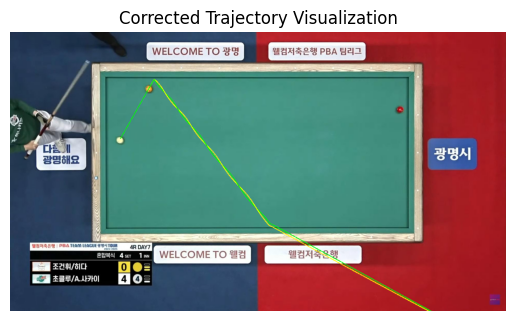

In [14]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

##############################################################################
# 0) 헬퍼 함수: GPU 텐서 -> CPU float 변환
##############################################################################
def to_cpu_float(value):
    """
    텐서(tensor)이거나 일반 파이썬 숫자 타입 여부에 상관없이
    안전하게 float으로 변환해주는 함수입니다.

    - torch.Tensor인 경우:
      value.detach().cpu().item()을 통해 CPU 상의 단일 숫자로 추출 후 float으로 변환.
    - 그 외(float/int 등)는 그냥 float(value)로 처리.
    """
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

##############################################################################
# 1) 흰 공, 목표 공 좌표 추출 + 테이블 좌표
##############################################################################
# - YOLO에서 검출된 결과(objects) 중 흰 공(white ball)과
#   목표 공(red ball 또는 yellow ball)을 선택.
# - 각 공의 바운딩 박스 (x1,y1,x2,y2) 정보로부터 중심 좌표(픽셀)를 계산.
# - 픽셀 좌표를 Pymunk 월드 좌표(미터 단위)로 변환하기 위해
#   픽셀:미터 스케일(예: 100픽셀 = 1m)을 설정.
##############################################################################

# 1) YOLO 결과에서 흰 공과 목표 공을 찾음
white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
target_ball = next(obj for obj in objects if obj["cls_name"] in ["red ball", "yellow ball"])

# 2) 바운딩 박스 좌표를 안전하게 float으로 변환
wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])
tx1, ty1 = to_cpu_float(target_ball["x1"]), to_cpu_float(target_ball["y1"])
tx2, ty2 = to_cpu_float(target_ball["x2"]), to_cpu_float(target_ball["y2"])

# 3) 바운딩 박스 중심점(픽셀 좌표) 계산
white_pos = np.array([(wx1 + wx2) / 2.0, (wy1 + wy2) / 2.0])
target_pos = np.array([(tx1 + tx2) / 2.0, (ty1 + ty2) / 2.0])

# 4) 픽셀 → 월드 좌표 스케일링
PIXELS_TO_METERS = 100.0
white_pos_world = (white_pos / PIXELS_TO_METERS).tolist()
target_pos_world = (target_pos / PIXELS_TO_METERS).tolist()

##############################################################################
# 2) Pymunk 초기화 + 테이블 경계 생성
##############################################################################
# - Pymunk Space를 만들고 중력(0,0)으로 설정(수평 테이블 가정).
# - 테이블의 좌하단, 우상단 좌표를 이용해 4면(쿠션)을 만들고,
#   쿠션 탄성(elasticity)과 마찰(friction)을 설정해 공의 반사/마찰 효과를 모사.
##############################################################################
space = pymunk.Space()
space.gravity = (0, 0)

table_world_min = (table["x1"] / PIXELS_TO_METERS, table["y1"] / PIXELS_TO_METERS)
table_world_max = (table["x2"] / PIXELS_TO_METERS, table["y2"] / PIXELS_TO_METERS)

cushion_thickness = 0.01
cushions = [
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_min[1]), 
                   (table_world_max[0], table_world_min[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_max[1]), 
                   (table_world_max[0], table_world_max[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_min[0], table_world_min[1]), 
                   (table_world_min[0], table_world_max[1]), 
                   cushion_thickness),
    pymunk.Segment(space.static_body, 
                   (table_world_max[0], table_world_min[1]), 
                   (table_world_max[0], table_world_max[1]), 
                   cushion_thickness),
]

# 쿠션 탄성 & 마찰 설정 후 Space에 추가
for c in cushions:
    c.elasticity = 0.7  # 현실적인 반사각
    c.friction = 0.1   # 쿠션 마찰
    space.add(c)

##############################################################################
# 3) 공 생성 (동적)
##############################################################################
# - pymunk에서 공은 Body + Circle Shape으로 구성.
# - Body는 질량, 관성(moment) 등을 가지고, Shape는 반지름, 탄성, 마찰 등을 설정.
# - 충돌 타입(collision_type)을 지정해 서로 다른 객체끼리 충돌 처리를 구분할 수 있음.
##############################################################################
mass = 1.0
radius = 0.05  # 반지름(5cm)
moment = pymunk.moment_for_circle(mass, 0, radius)

# 흰 공
white_ball_body = pymunk.Body(mass, moment)
white_ball_body.position = white_pos_world
white_ball_shape = pymunk.Circle(white_ball_body, radius)
white_ball_shape.elasticity = 0.7
white_ball_shape.friction = 0.1
white_ball_shape.collision_type = 0  # 충돌 분류 ID
space.add(white_ball_body, white_ball_shape)

# 목표 공
target_ball_body = pymunk.Body(mass, moment)
target_ball_body.position = target_pos_world
target_ball_shape = pymunk.Circle(target_ball_body, radius)
target_ball_shape.elasticity = 0.7
target_ball_shape.friction = 0.1
target_ball_shape.collision_type = 1  # 충돌 분류 ID
space.add(target_ball_body, target_ball_shape)

##############################################################################
# 4) 흰 공 초기 속도 설정
##############################################################################
# - 흰 공이 목표 공을 향하도록 방향 벡터 및 거리(distance)를 계산.
# - 일정 강도(strength)를 주어 흰 공을 밀어냄.
# - 최소 속도를 설정하여 거리 짧아도 너무 약하게 치지 않도록 함.
##############################################################################
direction_vector = target_ball_body.position - white_ball_body.position
distance = direction_vector.length
direction_unit = direction_vector.normalized() if distance > 0 else Vec2d(1, 0)

# 최대 거리 15m, 그에 따라 최대 강도 10; 최소 강도 2 보장
strength = max(min((distance / 15.0) * 10, 10), 2)
white_ball_body.velocity = direction_unit * strength * 2.0

print(f"[초기 설정] 흰 공 초기 속도: {white_ball_body.velocity}, 힘: {strength}")

##############################################################################
# 5) 충돌 핸들러: 충돌 후 속도 및 방향 보정
##############################################################################
# - post_solve 콜백에서 흰 공과 목표 공의 속도를 각각 계산해주며
#   실제 물리와 유사하게 충격량을 나누도록 설정 (공간분리, 에너지 손실 등을 고려).
##############################################################################
def handle_collision(arbiter, space, data):
    """
    흰 공과 목표 공이 충돌했을 때의 처리:
    - 충돌 법선 벡터를 이용해 충격량(impulse)를 계산.
    - 흰 공/목표 공의 속도를 적절히 보정(에너지 손실/전달).
    - 디버깅용 로그 출력.
    """
    shapes = arbiter.shapes
    white_body = shapes[0].body
    target_body = shapes[1].body

    # 충돌 법선 벡터
    collision_normal = arbiter.contact_point_set.normal

    # 상대 속도
    relative_velocity = white_body.velocity - target_body.velocity
    # 충돌 시의 충격량(impulse) = (상대속도 ⋅ 법선) * 법선
    impulse = relative_velocity.dot(collision_normal) * collision_normal

    # 충돌 후 속도 보정 (0.8 배)
    white_body.velocity -= impulse * 0.8
    target_body.velocity += impulse * 0.8

    print(f"[충돌 발생] 법선 벡터: {collision_normal}")
    print(f"[충돌 발생] 충격량(impulse): {impulse}")
    print(f"[충돌 발생] 흰 공 속도: {white_body.velocity}, 목표 공 속도: {target_body.velocity}")
    return True

collision_handler = space.add_collision_handler(0, 1)
collision_handler.post_solve = handle_collision

##############################################################################
# 6) 시뮬레이션 수행
##############################################################################
# - 매 스텝마다 space.step(dt)을 통해 물리 엔진 업데이트.
# - 흰 공과 목표 공의 속도가 stop_threshold 미만이면 0으로 설정(멈춤).
# - 둘 다 멈추면 시뮬레이션 종료.
##############################################################################
friction_coefficient = 0.01  # 별도 수동 마찰용 변수(현재는 코드 내 미사용)
dt = 1 / 60.0
max_steps = 3000
stop_threshold = 0.02

positions_w, positions_t = [], []  # 흰 공과 목표 공 위치 기록

for step in range(max_steps):
    # 한 스텝 시뮬레이션
    space.step(dt)

    # 속도가 너무 낮으면 멈춤 처리
    if white_ball_body.velocity.length < stop_threshold:
        white_ball_body.velocity = Vec2d(0, 0)
    if target_ball_body.velocity.length < stop_threshold:
        target_ball_body.velocity = Vec2d(0, 0)

    # 현재 위치 기록
    positions_w.append((white_ball_body.position.x, white_ball_body.position.y))
    positions_t.append((target_ball_body.position.x, target_ball_body.position.y))

    # 디버깅용으로 100 스텝마다 로그 출력
    if step % 100 == 0:
        print(f"[Step {step}] 흰 공 속도: {white_ball_body.velocity.length:.2f}, "
              f"목표 공 속도: {target_ball_body.velocity.length:.2f}")

    # 두 공이 모두 멈추면 조기 종료
    if (white_ball_body.velocity.length < stop_threshold and
        target_ball_body.velocity.length < stop_threshold):
        print(f"[시뮬레이션 종료] Step {step}")
        break

##############################################################################
# 7) 최종 궤적 시각화
##############################################################################
# - OpenCV로 원본 이미지에 흰 공(초록), 목표 공(노랑) 궤적을 선으로 연결.
# - 최종 위치에 원을 그려 위치 표시 후, matplotlib로 보여줌.
##############################################################################

# 최종 위치를 픽셀 좌표로 변환
final_white_pos = white_ball_body.position * PIXELS_TO_METERS
final_target_pos = target_ball_body.position * PIXELS_TO_METERS

print(f"[최종 위치] 흰 공: ({final_white_pos.x:.2f}, {final_white_pos.y:.2f})")
print(f"[최종 위치] 목표 공: ({final_target_pos.x:.2f}, {final_target_pos.y:.2f})")

# 원본 이미지 로드
image = cv2.imread(image_path)

# 흰 공 / 목표 공 궤적 그리기
for i in range(len(positions_w) - 1):
    # 흰 공 궤적
    px_w1, py_w1 = int(positions_w[i][0] * PIXELS_TO_METERS), int(positions_w[i][1] * PIXELS_TO_METERS)
    px_w2, py_w2 = int(positions_w[i + 1][0] * PIXELS_TO_METERS), int(positions_w[i + 1][1] * PIXELS_TO_METERS)
    cv2.line(image, (px_w1, py_w1), (px_w2, py_w2), (0, 255, 0), 2)  # 초록색 선

    # 목표 공 궤적
    px_t1, py_t1 = int(positions_t[i][0] * PIXELS_TO_METERS), int(positions_t[i][1] * PIXELS_TO_METERS)
    px_t2, py_t2 = int(positions_t[i + 1][0] * PIXELS_TO_METERS), int(positions_t[i + 1][1] * PIXELS_TO_METERS)
    cv2.line(image, (px_t1, py_t1), (px_t2, py_t2), (0, 255, 255), 2)  # 노란색 선

# 최종 위치를 원으로 표시
cv2.circle(image, (int(final_white_pos.x), int(final_white_pos.y)), 10, (0, 255, 0), -1)    # 흰 공
cv2.circle(image, (int(final_target_pos.x), int(final_target_pos.y)), 10, (0, 255, 255), -1) # 목표 공

# 색상 채널 BGR->RGB 변환 후 Matplotlib에 표시
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Corrected Trajectory Visualization")
plt.show()


Exception ignored from cffi callback <function ext_cpCollisionPostSolveFunc at 0x7a791e13c040>:
Traceback (most recent call last):
  File "/aiffel/myenv/lib/python3.9/site-packages/pymunk/_callbacks.py", line 253, in ext_cpCollisionPostSolveFunc
    handler._post_solve(Arbiter(_arb, handler._space), handler._space, handler.data)
  File "/tmp/ipykernel_80/4043997022.py", line 11, in handle_collision
AttributeError: 'ContactPoint' object has no attribute 'normal'
Exception ignored from cffi callback <function ext_cpCollisionPostSolveFunc at 0x7a791e13c040>:
Traceback (most recent call last):
  File "/aiffel/myenv/lib/python3.9/site-packages/pymunk/_callbacks.py", line 253, in ext_cpCollisionPostSolveFunc
    handler._post_solve(Arbiter(_arb, handler._space), handler._space, handler.data)
  File "/tmp/ipykernel_80/4043997022.py", line 11, in handle_collision
AttributeError: 'ContactPoint' object has no attribute 'normal'
Exception ignored from cffi callback <function ext_cpCollisionPostSo

[Step 0] 흰 공 속도: 0.25, 목표 공 속도: 0.36
[Step 100] 흰 공 속도: 0.25, 목표 공 속도: 0.36
[Step 200] 흰 공 속도: 0.25, 목표 공 속도: 0.36
[Step 300] 흰 공 속도: 0.25, 목표 공 속도: 0.36
[Step 400] 흰 공 속도: 0.25, 목표 공 속도: 0.36
[Step 500] 흰 공 속도: 0.25, 목표 공 속도: 0.36
[Step 600] 흰 공 속도: 0.25, 목표 공 속도: 0.21
[Step 700] 흰 공 속도: 0.25, 목표 공 속도: 0.21
[Step 800] 흰 공 속도: 0.25, 목표 공 속도: 0.21
[Step 900] 흰 공 속도: 0.25, 목표 공 속도: 0.21
[Step 1000] 흰 공 속도: 0.25, 목표 공 속도: 0.21
[Step 1100] 흰 공 속도: 0.25, 목표 공 속도: 0.21
[Step 1200] 흰 공 속도: 0.15, 목표 공 속도: 0.21
[Step 1300] 흰 공 속도: 0.15, 목표 공 속도: 0.21
[Step 1400] 흰 공 속도: 0.15, 목표 공 속도: 0.21
[Step 1500] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 1600] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 1700] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 1800] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 1900] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 2000] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 2100] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 2200] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 2300] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 2400] 흰 공 속도: 0.15, 목표 공 속도: 0.17
[Step 2500] 

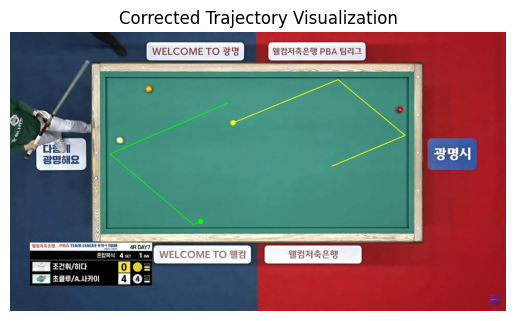


0: 960x1280 1 frame, 1 red ball, 1 table, 1 white ball, 1 yellow ball, 38.3ms
Speed: 7.1ms preprocess, 38.3ms inference, 1.7ms postprocess per image at shape (1, 3, 960, 1280)
Table: {'cls_name': 'table', 'x1': tensor(160.3016, device='cuda:0'), 'y1': tensor(139.6972, device='cuda:0'), 'x2': tensor(640.8237, device='cuda:0'), 'y2': tensor(461.1335, device='cuda:0'), 'confidence': tensor(0.9169, device='cuda:0')}
Objects: [{'cls_name': 'white ball', 'x1': tensor(182.7551, device='cuda:0'), 'y1': tensor(195.2361, device='cuda:0'), 'x2': tensor(195.7133, device='cuda:0'), 'y2': tensor(211.7339, device='cuda:0'), 'confidence': tensor(0.9058, device='cuda:0')}, {'cls_name': 'yellow ball', 'x1': tensor(196.8719, device='cuda:0'), 'y1': tensor(143.4083, device='cuda:0'), 'x2': tensor(209.1276, device='cuda:0'), 'y2': tensor(159.0325, device='cuda:0'), 'confidence': tensor(0.8636, device='cuda:0')}, {'cls_name': 'frame', 'x1': tensor(142.9353, device='cuda:0'), 'y1': tensor(99.4082, device='c

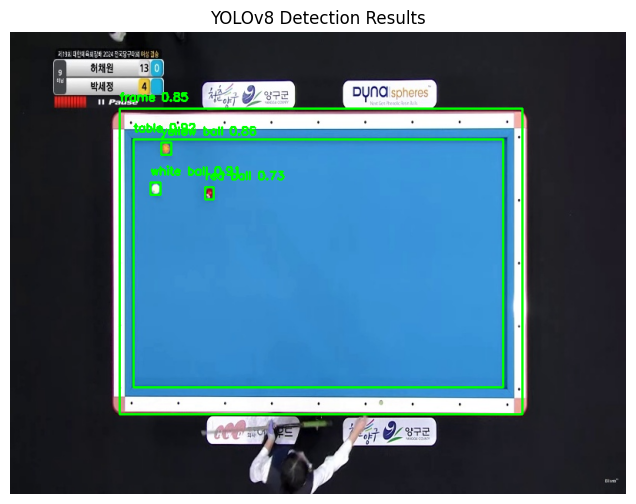

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline  

from ultralytics import YOLO
import cv2
import torch

##############################################################################
# 1) YOLO 모델 로드
##############################################################################
# - ultralytics 라이브러리에서 제공하는 YOLO 클래스를 사용해 모델을 로드합니다.
# - best_jihye.pt 파일은 사전에 학습된 모델 가중치 파일입니다.
##############################################################################
model_path = "best_jihye.pt"
model = YOLO(model_path)

##############################################################################
# 2) 이미지 로드
##############################################################################
# - OpenCV(cv2)의 imread 함수를 통해 로컬에 저장된 이미지를 불러옵니다.
# - 이미지가 존재하지 않는 경우 FileNotFoundError 예외를 발생시킵니다.
##############################################################################
image_path = "frame_980.jpg"
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image: {image_path}")

##############################################################################
# 3) 모델 추론
##############################################################################
# - 모델에 이미지를 입력하여 객체 탐지(prediction)를 수행합니다.
# - conf=0.5로 설정해 신뢰도(confidence)가 0.5 이상인 바운딩 박스만 추출합니다.
##############################################################################
results = model.predict(source=image, conf=0.5)

##############################################################################
# 4) 당구대(table), 다른 공 및 객체(objects) 저장할 구조
##############################################################################
# - table 변수를 통해 테이블(당구대) 정보를 저장합니다.
# - objects 리스트에는 공(blue ball, red ball 등) 및 기타 객체들의 정보를 저장합니다.
##############################################################################
table = None
objects = []

##############################################################################
# 5) 바운딩 박스 표시 및 table/objects 분류
##############################################################################
# - 모델 추론 결과 중 boxes를 순회하면서 각 객체의 바운딩 박스를 그립니다.
# - 클래스 ID를 실제 클래스 명으로 매핑하고, 당구대(table)이면 table,
#   그렇지 않으면 objects 리스트에 정보를 저장합니다.
# - OpenCV로 시각화(사각형과 클래스명+신뢰도 텍스트)를 그립니다.
##############################################################################
for result in results:
    for box in result.boxes:
        # 바운딩 박스 정보 (xyxy: [x1, y1, x2, y2])
        x1, y1, x2, y2 = box.xyxy[0]
        conf = box.conf[0]  # 신뢰도
        cls_id = int(box.cls[0])  # 클래스 ID

        # OpenCV 사각형 그리기 위해 정수 변환
        ix1, iy1, ix2, iy2 = map(int, [x1, y1, x2, y2])

        # 클래스 ID와 실제 이름 매핑
        class_map = {
            0: "blue ball", 
            1: "frame", 
            2: "red ball", 
            3: "table",
            4: "white ball", 
            5: "yellow ball"
        }
        cls_name = class_map.get(cls_id, f"Unknown({cls_id})")

        # 바운딩 박스 그리기 (녹색)
        cv2.rectangle(image, (ix1, iy1), (ix2, iy2), (0, 255, 0), 2)

        # 라벨(클래스명 + 신뢰도) 출력
        label = f"{cls_name} {conf:.2f}"
        cv2.putText(
            image, label, (ix1, max(iy1 - 10, 0)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
        )

        # 테이블/객체 분류
        if cls_id == 3:  # table
            table = {
                "cls_name": "table",
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "confidence": conf
            }
        else:
            objects.append({
                "cls_name": cls_name,
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "confidence": conf
            })

##############################################################################
# 테이블이 검출되지 않은 경우 기본값 설정
##############################################################################
# - 예: 자동으로 (0,0,1280,720)을 테이블 영역으로 간주
##############################################################################
if table is None:
    table = {
        "cls_name": "table(default)",
        "x1": 0, "y1": 0, "x2": 1280, "y2": 720,
        "confidence": 1.0
    }

##############################################################################
# 결과 확인 (터미널 출력)
##############################################################################
print("Table:", table)
print("Objects:", objects)

##############################################################################
# 시각화 (디버깅용)
##############################################################################
# - OpenCV로 그렸던 이미지는 BGR 포맷이므로, Matplotlib에 표시하기 위해 RGB로 변환
# - 바운딩 박스와 라벨이 표시된 이미지를 확인합니다.
##############################################################################
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("YOLOv8 Detection Results")
plt.show()


[충돌] bodyA vel=Vec2d(0.009868903312551249, -0.037469835847383975), bodyB vel=Vec2d(0.09401428945113635, -0.35694948886192396)
[충돌] bodyA vel=Vec2d(0.0035032088146758856, -0.0130532887198828), bodyB vel=Vec2d(0.10001022258184179, 0.2890327096161657)
[충돌] bodyA vel=Vec2d(-0.06326369862168583, 0.21605110624303123), bodyB vel=Vec2d(0.16324058446266704, 0.07288525913659571)
[충돌] bodyA vel=Vec2d(-0.06324261072214528, 0.21597908920761688), bodyB vel=Vec2d(0.16318617093451282, 0.07286096405021686)
[최종 위치] 흰 공: (306.97, 159.64)
[최종 위치] 목표 공: (563.07, 378.31)


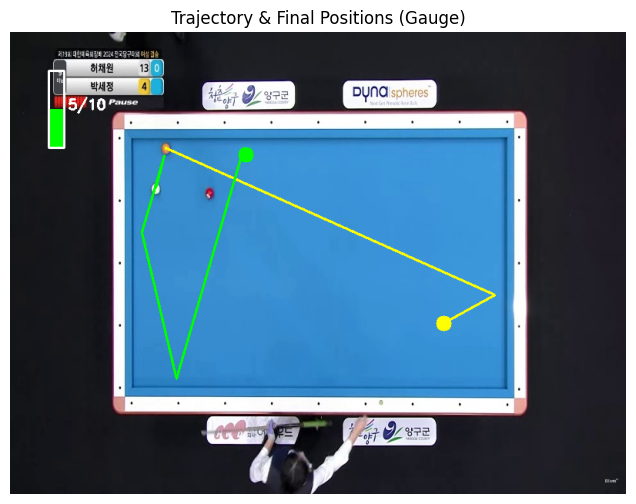

In [6]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

##############################################################################
# 0) 헬퍼 함수: GPU 텐서 -> CPU float 변환
##############################################################################
def to_cpu_float(value):
    """
    텐서(tensor)이거나 일반 파이썬 숫자 타입 여부에 상관없이
    안전하게 float으로 변환해주는 함수입니다.

    - torch.Tensor인 경우: 
        value.detach().cpu().item()을 통해 CPU 상의 단일 숫자로 추출 후 float으로 변환
    - 그 외(float/int 등)는 그냥 float(value)로 처리
    """
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)


##############################################################################
# 1) 흰 공, 목표 공 좌표 추출 + 테이블 좌표
##############################################################################
# - YOLO 탐지 결과(objects) 중 'white ball'(흰 공)과
#   'red ball' 또는 'yellow ball'(목표 공) 데이터를 찾음.
# - 각 공의 바운딩 박스 (x1,y1,x2,y2) 중심점을 픽셀 좌표로 계산.
# - 이후 픽셀 → 월드 좌표 변환 스케일(PIXELS_TO_METERS)에 따라 실제 물리 좌표로 변환.
##############################################################################
white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
target_ball = next(obj for obj in objects if obj["cls_name"] in ["red ball", "yellow ball"])

# x1, y1, x2, y2 좌표를 안전하게 변환 (GPU 텐서일 수도 있으므로 to_cpu_float 사용)
wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])
tx1, ty1 = to_cpu_float(target_ball["x1"]), to_cpu_float(target_ball["y1"])
tx2, ty2 = to_cpu_float(target_ball["x2"]), to_cpu_float(target_ball["y2"])

# 바운딩 박스 중심점(픽셀 단위)
white_pos = np.array([(wx1 + wx2) / 2.0, (wy1 + wy2) / 2.0])
target_pos = np.array([(tx1 + tx2) / 2.0, (ty1 + ty2) / 2.0])

# 픽셀 → 월드 좌표로 변환 (예: 100 픽셀 = 1 m)
PIXELS_TO_METERS = 100.0
white_pos_world = (white_pos / PIXELS_TO_METERS).tolist()
target_pos_world = (target_pos / PIXELS_TO_METERS).tolist()


##############################################################################
# 2) Pymunk 초기화
##############################################################################
# - 물리 시뮬레이션 엔진인 pymunk의 Space() 객체 생성.
# - 중력을 (0, 0)으로 설정해 수평 테이블처럼 보이도록 함.
##############################################################################
space = pymunk.Space()
space.gravity = (0, 0)

# 테이블 정보 (월드 좌표)
# 테이블의 좌하단(x1,y1), 우상단(x2,y2)을 미터 단위로 변환
table_min_x = table["x1"] / PIXELS_TO_METERS
table_min_y = table["y1"] / PIXELS_TO_METERS
table_max_x = table["x2"] / PIXELS_TO_METERS
table_max_y = table["y2"] / PIXELS_TO_METERS


##############################################################################
# 3) 공 생성에 필요한 파라미터
##############################################################################
# - 공의 질량(mass), 반지름(radius), 관성모멘트(moment) 계산
# - pymunk.moment_for_circle()는 원형 물체의 관성모멘트를 구해줌
##############################################################################
mass = 1.0
radius = 0.05  # 5cm
moment = pymunk.moment_for_circle(mass, 0, radius)


##############################################################################
# 4) 테이블 경계 생성 - 쿠션(4개 세그먼트)
##############################################################################
# - 공이 테이블 밖으로 나가지 않도록 테이블 내벽(쿠션)을 4개 Segment로 생성.
# - 쿠션을 실제 테이블 경계보다 '공 반지름(r)'만큼 안쪽에 위치시켜,
#   공이 쿠션과 닿을 때 테이블 밖으로 넘치지 않도록 함.
##############################################################################
left   = table_min_x + radius
right  = table_max_x - radius
bottom = table_min_y + radius
top    = table_max_y - radius

# 쿠션 두께 (Segment의 반지름 역할)
cushion_thickness = 0.01

cushions = [
    pymunk.Segment(space.static_body, (left,  bottom), (right, bottom), cushion_thickness),
    pymunk.Segment(space.static_body, (left,  top),    (right, top),    cushion_thickness),
    pymunk.Segment(space.static_body, (left,  bottom), (left,  top),    cushion_thickness),
    pymunk.Segment(space.static_body, (right, bottom), (right, top),    cushion_thickness),
]

for c in cushions:
    c.elasticity = 0.9   # 공이 쿠션과 충돌할 때의 반사 정도
    c.friction = 0.01    # 쿠션과의 마찰 (너무 높으면 쿠션이 공을 많이 느리게 함)
    space.add(c)


##############################################################################
# 5) 흰 공과 노란(또는 빨간) 공 생성
##############################################################################
# - Body(동적) + Circle Shape 생성
# - elasticity, friction 등 충돌/마찰 파라미터 설정
# - collision_type을 달리 지정(1, 2)해 충돌 핸들러에서 구분 가능
##############################################################################
# 흰 공
white_ball_body = pymunk.Body(mass, moment)
white_ball_body.position = white_pos_world  # 월드 좌표
white_ball_shape = pymunk.Circle(white_ball_body, radius)
white_ball_shape.elasticity = 0.9
white_ball_shape.friction = 0.05
white_ball_shape.collision_type = 1
space.add(white_ball_body, white_ball_shape)

# 목표 공
target_ball_body = pymunk.Body(mass, moment)
target_ball_body.position = target_pos_world
target_ball_shape = pymunk.Circle(target_ball_body, radius)
target_ball_shape.elasticity = 0.9
target_ball_shape.friction = 0.05
target_ball_shape.collision_type = 2
space.add(target_ball_body, target_ball_shape)


##############################################################################
# 6) 충돌 핸들러 등록
##############################################################################
# - collision_type=1(흰 공), 2(목표 공)가 충돌 시 실행할 콜백 함수 on_collision 등록
# - 여기서는 충돌 시 별도 속도 조정은 하지 않고, 로그만 출력
##############################################################################
def on_collision(arbiter, space, data):
    """
    Pymunk 기본 탄성 처리에 맡기되, 로그만 출력(필요하다면).
    충돌 시 속도를 임의로 조정하지 않고, 
    pymunk 내부 물리 계산(탄성, 마찰)에 맡김.
    """
    shapes = arbiter.shapes
    bodyA = shapes[0].body
    bodyB = shapes[1].body
    print(f"[충돌] bodyA vel={bodyA.velocity}, bodyB vel={bodyB.velocity}")
    return True  # 충돌 지속 허용

# 1번과 2번 충돌 타입의 post_solve(충돌 후 처리)에 on_collision 할당
collision_handler = space.add_collision_handler(1, 2)
collision_handler.post_solve = on_collision


##############################################################################
# 7) 흰 공 초기 속도(게이지) 부여
##############################################################################
# - 게이지를 1~10 범위로 가정, 그 중 strength_gauge를 통해 속도 계산
# - 게이지 10일 때 최대 속도 5m/s(예시), 그 이하 비례
##############################################################################
strength_gauge = 5    # 예: 게이지 값 (1~10 범위)
max_speed = 5.0       # 게이지 10일 때 5 m/s
initial_speed = (strength_gauge / 60.0) * max_speed  
# 여기서는 (게이지 / 60)이라는 임의 비율로 속도를 만든 예시. 
# 실제 비율은 원하는 대로 조정 가능.

# 흰 공 → 목표 공 방향 벡터
direction_vec = (target_ball_body.position - white_ball_body.position)
distance = direction_vec.length
direction_unit = direction_vec.normalized() if distance > 0 else Vec2d(1, 0)

# 초기 속도 설정
white_ball_body.velocity = direction_unit * initial_speed


##############################################################################
# 8) 시뮬레이션 실행
##############################################################################
# - 일정 시간(dt) 간격으로 space.step(dt)을 호출해 물리 엔진 업데이트
# - global_friction_coef 등으로 공의 속도를 추가적으로 감소시켜
#   테이블 마찰 효과를 좀 더 크게 모사
# - 공들이 모두 멈추면 시뮬레이션 종료
##############################################################################
dt = 1/60.0
max_steps = 3000
stop_threshold = 0.02  # 속도가 이 이하이면 멈췄다고 간주

positions_w, positions_t = [], []  # 흰 공, 목표 공 위치 기록

# 테이블 전체 마찰 효과 (추가)
global_friction_coef = 0.02

for step in range(max_steps):
    space.step(dt)

    # 추가 마찰: 매 프레임 공 속도를 일정 비율 감소
    white_ball_body.velocity *= (1 - global_friction_coef * dt)
    target_ball_body.velocity *= (1 - global_friction_coef * dt)

    # 속도가 작으면 0으로 설정(완전 정지)
    if white_ball_body.velocity.length < stop_threshold:
        white_ball_body.velocity = Vec2d(0, 0)
    if target_ball_body.velocity.length < stop_threshold:
        target_ball_body.velocity = Vec2d(0, 0)

    # 좌표 기록 (시각화용)
    positions_w.append((white_ball_body.position.x, white_ball_body.position.y))
    positions_t.append((target_ball_body.position.x, target_ball_body.position.y))

    # 둘 다 멈추면 시뮬레이션 종료
    if (white_ball_body.velocity.length == 0 and
        target_ball_body.velocity.length == 0):
        print(f"[시뮬레이션 종료] Step {step}")
        break


##############################################################################
# 9) 결과 출력 (최종 위치)
##############################################################################
final_white_pos = white_ball_body.position * PIXELS_TO_METERS
final_target_pos = target_ball_body.position * PIXELS_TO_METERS

print(f"[최종 위치] 흰 공: ({final_white_pos.x:.2f}, {final_white_pos.y:.2f})")
print(f"[최종 위치] 목표 공: ({final_target_pos.x:.2f}, {final_target_pos.y:.2f})")


##############################################################################
# 10) 궤적 시각화
##############################################################################
# - OpenCV로 원본 이미지 위에 흰 공(초록색), 목표 공(노란색) 궤적을 그리고,
#   최종 위치에 원(circle) 표시
##############################################################################
image = cv2.imread(image_path)

# 각 스텝에서 흰 공, 목표 공의 위치를 선분으로 연결
for i in range(len(positions_w) - 1):
    px_w1, py_w1 = int(positions_w[i][0] * PIXELS_TO_METERS), int(positions_w[i][1] * PIXELS_TO_METERS)
    px_w2, py_w2 = int(positions_w[i+1][0] * PIXELS_TO_METERS), int(positions_w[i+1][1] * PIXELS_TO_METERS)
    cv2.line(image, (px_w1, py_w1), (px_w2, py_w2), (0, 255, 0), 2)  # 흰 공: 녹색 라인

    px_t1, py_t1 = int(positions_t[i][0] * PIXELS_TO_METERS), int(positions_t[i][1] * PIXELS_TO_METERS)
    px_t2, py_t2 = int(positions_t[i+1][0] * PIXELS_TO_METERS), int(positions_t[i+1][1] * PIXELS_TO_METERS)
    cv2.line(image, (px_t1, py_t1), (px_t2, py_t2), (0, 255, 255), 2)  # 목표 공: 노란색 라인

# 최종 위치에 원(circle) 표시
cv2.circle(image, (int(final_white_pos.x), int(final_white_pos.y)), 10, (0, 255, 0), -1)      # 흰 공
cv2.circle(image, (int(final_target_pos.x), int(final_target_pos.y)), 10, (0, 255, 255), -1) # 목표 공


##############################################################################
# 11) 강도 게이지 표시 (좌측 상단)
##############################################################################
# - 게이지를 시각적으로 표시하기 위해 사각형을 그려 채우는 방식 사용
##############################################################################
gauge_max_height = 100  # 게이지의 최대 높이
gauge_height = int((strength_gauge / 10) * gauge_max_height)  # 게이지 값(1~10)에 따른 높이
gauge_x, gauge_y = 50, 50  # 게이지 바의 왼쪽 상단 좌표
gauge_width = 20          # 게이지 바의 폭

# 채워진 게이지 부분 (녹색)
cv2.rectangle(
    image,
    (gauge_x, gauge_y + gauge_max_height - gauge_height),
    (gauge_x + gauge_width, gauge_y + gauge_max_height),
    (0, 255, 0),
    -1
)

# 게이지 바 테두리 (흰색)
cv2.rectangle(
    image,
    (gauge_x, gauge_y),
    (gauge_x + gauge_width, gauge_y + gauge_max_height),
    (255, 255, 255),
    2
)

# 텍스트로 게이지 수치 표시
cv2.putText(
    image,
    f"{strength_gauge}/10",
    (gauge_x + gauge_width + 5, gauge_y + gauge_max_height // 2),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.6,
    (255, 255, 255),
    2
)


# 최종 시각화 (Matplotlib에서 표시)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Trajectory & Final Positions (Gauge)")
plt.show()
